In [18]:
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [78]:
import pandas as pd

In [79]:
data = pd.read_csv('AirPassengers.csv', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [80]:
data

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

Text(0, 0.5, 'Passengers')

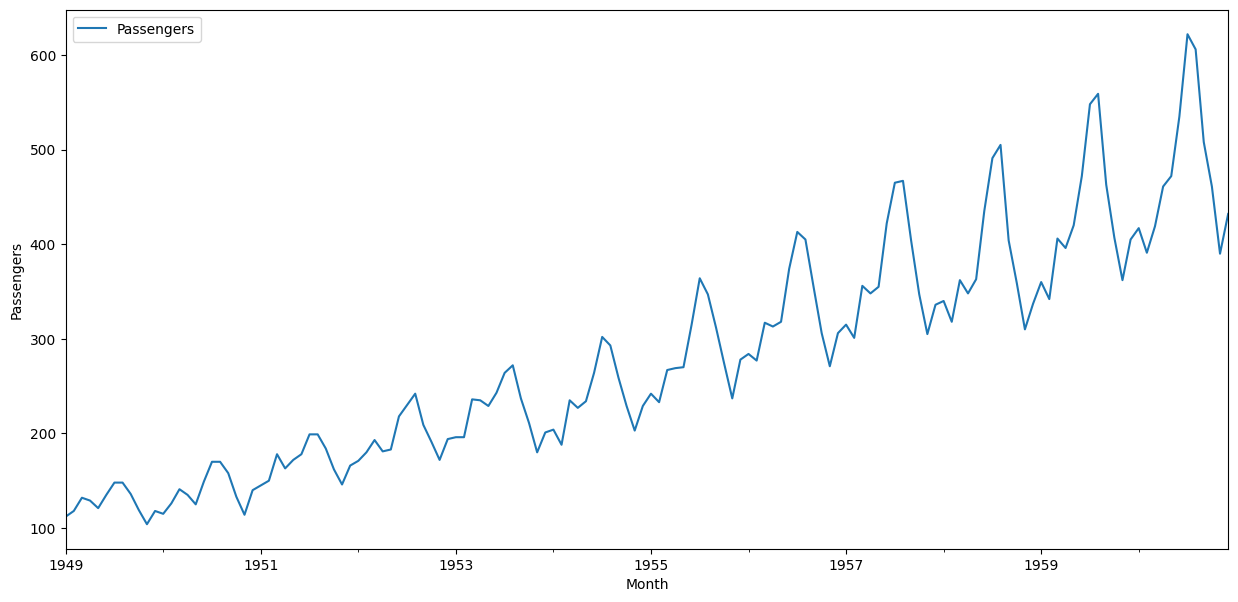

In [81]:
data.plot(figsize = (15,7))
plt.ylabel('Passengers')

In [82]:
series = np.array(data['Passengers'])
series.shape

(144,)

In [83]:
time = np.arange(len(data), dtype='float32')
time.shape

(144,)

In [88]:
split_time = 100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [110]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [111]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [112]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
model.fit(dataset,epochs=600,verbose=1)

Epoch 1/600
3/3 [==============================] - 0s 6ms/step - loss: 34783.2734
Epoch 2/600
3/3 [==============================] - 0s 5ms/step - loss: 6215.5522
Epoch 3/600
3/3 [==============================] - 0s 4ms/step - loss: 6558.9634
Epoch 4/600
3/3 [==============================] - 0s 5ms/step - loss: 4956.3691
Epoch 5/600
3/3 [==============================] - 0s 5ms/step - loss: 2879.2542
Epoch 6/600
3/3 [==============================] - 0s 4ms/step - loss: 2161.2026
Epoch 7/600
3/3 [==============================] - 0s 5ms/step - loss: 1960.2676
Epoch 8/600
3/3 [==============================] - 0s 7ms/step - loss: 1139.8528
Epoch 9/600
3/3 [==============================] - 0s 6ms/step - loss: 1882.3772
Epoch 10/600
3/3 [==============================] - 0s 4ms/step - loss: 840.1404
Epoch 11/600
3/3 [==============================] - 0s 5ms/step - loss: 1188.0104
Epoch 12/600
3/3 [==============================] - 0s 4ms/step - loss: 856.0555
Epoch 13/600
3/3 [========

In [113]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

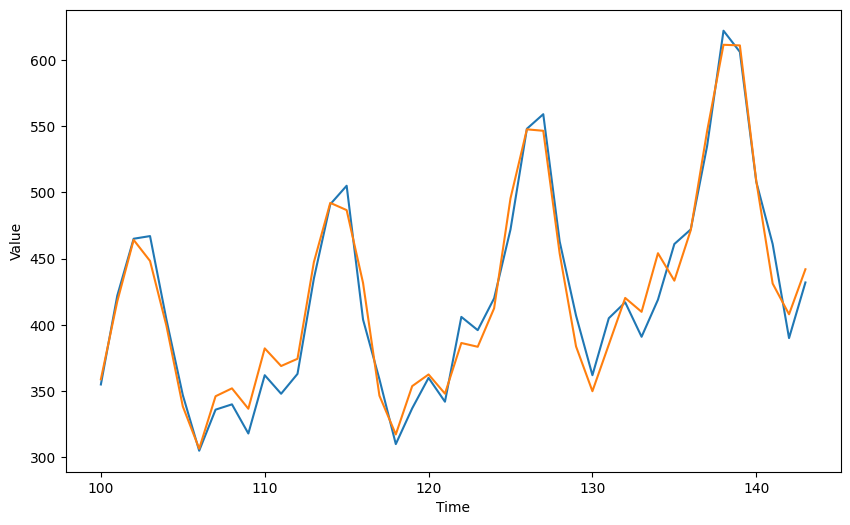

In [114]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [115]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

12.538113